In [1]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os
import glob

In [2]:
ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [12]:
gce_expandedflux = 'F:/Wetlands shapefiles/GCE flux tower/expanded_flux.shp' ## Added 9/18/23 - fix shapefile problems!

ss_gce = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE habitat map/SS.shp')
sm_gce = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE habitat map/SM.shp')
st_gce = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE habitat map/ST.shp')
mud_gce = geemap.shp_to_ee('F:/Wetlands shapefiles/GCE habitat map/mud.shp')

flux_ga = geemap.shp_to_ee(gce_expandedflux)

## DEM
elevation = ee.Image('USGS/3DEP/10m').clip(flux_ga) ##This is 1/3 arc second, or 10 m.

Map.addLayer(elevation)
Map

Map(bottom=107150.0, center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent…

In [28]:
#Elevation by habitat type
ss_elev = elevation.clip(ss_gce).select('elevation').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=flux_ga,
        scale=10
    ).get('elevation')

sm_elev = elevation.clip(sm_gce).select('elevation').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=flux_ga,
        scale=10
    ).get('elevation')

st_elev = elevation.clip(st_gce).select('elevation').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=flux_ga,
        scale=10
    ).get('elevation')

mud_elev = elevation.clip(mud_gce).select('elevation').reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=flux_ga,
        scale=10
    ).get('elevation')

# ss_elev #0.85 m 
# sm_elev #0.84 m
# st_elev #0.68 m
# mud_elev #0.33 m


In [4]:
Map.addLayer(ss_gce)
# Map

In [5]:
##FLATS

#12/08/22 - add calibrated flats to images
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))


##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)


# Function to add the date band
def add_date_band(image):
    # Get the acquisition date
    date = ee.Date(image.get('system:time_start'))
    
    # Convert the date to milliseconds since Unix epoch
    date_millis = date.millis()
    
    # Create an image with a single band representing the acquisition date
    date_image = ee.Image.constant(date_millis).int64().rename('acquisition_date')
    
    # Add the date image as a band to the original image
    return image.addBands(date_image)


#Function to add elevation

def add_elevation(image):
    elevation_band = elevation.rename('elevation')
    return image.addBands(elevation_band)

In [6]:
#Loading gee datasets
l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga) \
    .map(maskL5sr).map(addFLATSL8).map(add_date_band).map(add_elevation)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL7).map(add_date_band).map(add_elevation)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1984, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL5).map(add_date_band).map(add_elevation)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(flux_ga)\
    .map(maskL5sr).map(addFLATSL9).map(add_date_band).map(add_elevation)

In [7]:
# ##Batch processing to deal with memory issues

# # Function to calculate binary image for 'flats' values greater than the threshold
# def calculate_binary_image(image):
#     flats_band = image.select('flats')
#     binary_image = flats_band.gt(threshold)
#     return binary_image

# # Function to count valid pixels
# def count_valid_pixels(image):
#     valid_pixel_count = image.reduceRegion(
#         reducer=ee.Reducer.sum(),
#         geometry=study_area,
#         scale=30  # Assuming 30-meter resolution
#     ).get('flats')
#     return image.set('valid_pixel_count', valid_pixel_count)

# # Define a list of years to process
# years = list(range(1984, 2024))

# # Initialize an empty image collection
# result_images = ee.ImageCollection([])

# # Iterate over years
# for year in years:
#     # Filter the collection for the current year
#     year_collection = ultra.filter(ee.Filter.calendarRange(year, year, 'year'))
    
#     # Map the calculate_binary_image function
#     year_binary_images = year_collection.map(calculate_binary_image)
    
#     # Map the count_valid_pixels function
#     year_filtered_images = year_binary_images.map(count_valid_pixels)
    
#     # Filter images with a minimum valid pixel count
#     year_filtered_images = year_filtered_images.filter(ee.Filter.gte('valid_pixel_count', 50))
    
#     # Add the filtered images to the result collection
#     result_images = result_images.merge(year_filtered_images)

# # Reduce the result collection as needed
# total_count_image = result_images.sum()
# total_images = result_images.size()
# percentage_image = total_count_image.divide(total_images).multiply(100)



In [8]:
# #Directory
# out_dir = os.path.join("F:/Flats imagery")
# ##Draw geometry for exported images! It will look better

# bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

# image = percentage_image
# filename = os.path.join(out_dir, 'shortspartina_all.tif')

# image = image.clip(bb).unmask()

# # geemap.ee_export_image(
# #     image.select('flats'), filename=filename, scale=30, region=habmap.geometry(), file_per_band=True
# # )


EPSG:4326


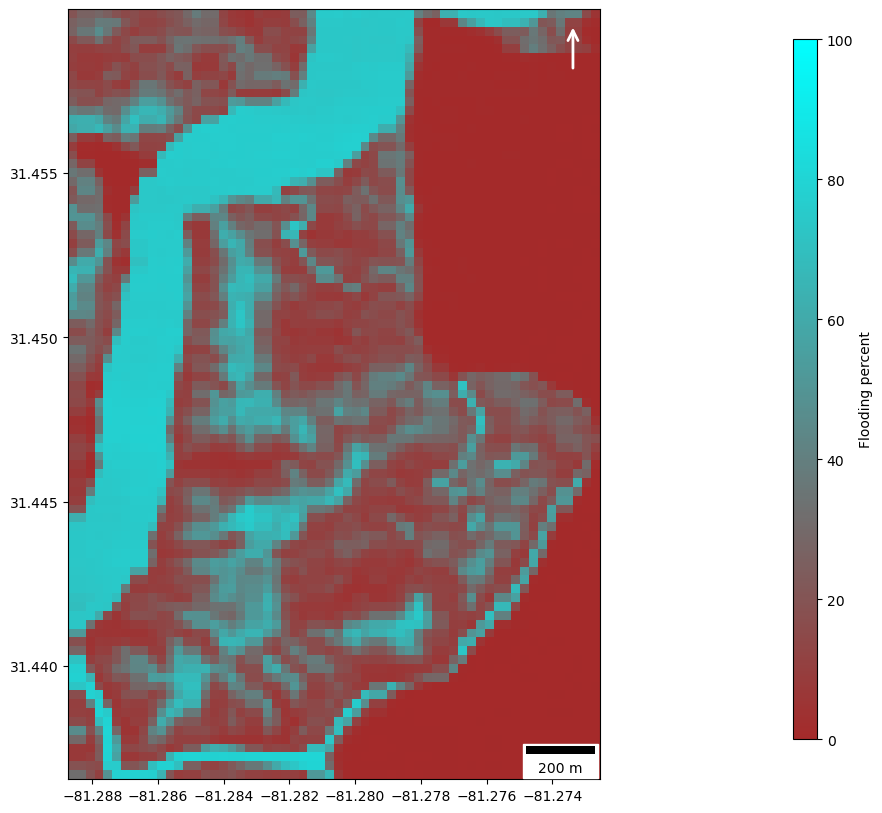

In [9]:
#Plotting
import matplotlib.colors as colors
from matplotlib_scalebar.scalebar import ScaleBar
import rasterio
import geopandas as gpd


bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

geotiff_path = "F:/Flats imagery/1984percentflats2023.flats.tif"

#Calculating dx for scale_bar
from geopy.distance import great_circle
point1 = (31.425,-81.29) 
point2 = (31.425,-80.29)  
dx = great_circle(point1, point2).meters

with rasterio.open(geotiff_path) as src:
        data = src.read(1)  # Assuming it's a single-band image
        extent = (src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top)    
        
        # Use a colormap with better visibility
        cmap = colors.LinearSegmentedColormap.from_list('custom', [(0, 'brown'), (1, 'aqua')])
        
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(12,10))
        
        # Plot the GeoTIFF data using imshow
        im = ax.imshow(data, extent=extent, cmap=cmap, vmin=0, vmax=100)

        # Remove coordinate labels to make the plots larger
#         ax.set_xticks([])
#         ax.set_yticks([])

        # Add a scale bar
        # Calculate the scale factor based on the pixel size (assuming meters)
        pixel_size_x = 30  # 30 meters in the x-direction
        scale_factor = pixel_size_x

        # Add a scale bar using the calculated scale factor
        scale_bar = ScaleBar(dx=dx, location='lower right')
        ax.add_artist(scale_bar)

        # Enhance the visibility of the north arrow
        ax.annotate('', xy=(0.95, 0.98), xycoords='axes fraction', fontsize=18, ha='center', va='center',
                    xytext=(0.95, 0.92), textcoords='axes fraction',
                    arrowprops=dict(arrowstyle='->', lw=2, color='white'))
        
        fig.subplots_adjust(right=0.95)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax, label = 'Flooding percent', cmap = \
                          colors.LinearSegmentedColormap.from_list('custom_gray', [(0, 'brown'), (1, 'aqua')]))
        
        
print(src.crs)


# Savefig
import os
os.chdir("C:/Users/arj26323/Downloads")
# plt.savefig('1983percent2023.png',bbox_inches='tight', dpi = 300)

In [10]:
bb = ee.Geometry.Polygon([[-81.29, 31.425], [-81.29, 31.46], [-81.27, 31.46],[-81.27, 31.425]])

ultra_col = l8_col.merge(l5_col).merge(l7_col).merge(l9_col)

ultra = ultra_col.filter(ee.Filter.calendarRange(1984, 2023,'year')).map(lambda image: image.clip(bb)) \
    .filter(ee.Filter.lte('CLOUD_COVER_LAND', 50))

#Percentage of pixels in study area flagged, ALL =----= MIGHT BE A BETTER WAY TO DO THIS

study_area = flux_ga.geometry()

# Define the threshold value
threshold = 0.2

# Function to calculate binary image for 'flats' values greater than the threshold
def calculate_binary_image(image):
    flats_band = image.select('flats')
    binary_image = flats_band.gt(threshold)
    return binary_image

# Map the function over the collection to get binary images
binary_images = ultra.map(calculate_binary_image)

# Function to count valid pixels
def count_valid_pixels(image):
    valid_pixel_count = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=study_area,
        scale=30  # Assuming 30-meter resolution
    ).get('flats')
    return image.set('valid_pixel_count', valid_pixel_count)

# Map the function over the binary images to count valid pixels
binary_images_with_count = binary_images.map(count_valid_pixels)

# Filter the collection to exclude scenes with fewer than 100 valid pixels
filtered_images = binary_images_with_count.filter(ee.Filter.gte('valid_pixel_count', 0))

# Reduce the filtered collection to a single image with pixel count
total_count_image = filtered_images.sum()

# Calculate the percentage of times each pixel exceeded the threshold
total_images = filtered_images.size()
percentage_image = total_count_image.divide(total_images).multiply(100)

Map = geemap.Map()
Map.centerObject(flux_ga, 14)
Map.addLayer(percentage_image, {
    'min': 0,
    'max': 100,
    'palette': ['brown', 'aqua']
}, 'Percentage of Times > 0.2')
Map

Map(center=[31.44565510385937, -81.28108052614698], controls=(WidgetControl(options=['position', 'transparent_…

In [11]:
Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

# Map.addLayer(percentage_image, {
#     'min': 0,
#     'max': 100,
#     'palette': ['brown', 'aqua']
# }, 'Percentage of Times > 0.2')

Map.addLayer(ss_gce)
# Map.addLayer(sm_gce)
Map.addLayer(st_gce)
Map.addLayer(mud_gce)

Map

Map(center=[31.539096, -81.422318], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBo…

In [20]:
filtered_images.sum()